In [1]:
pwd

u'/data/dv/Imaging/qingge/qingge-code'

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
import compute_int_samples

# Read outputs from compute_int_samples.py

In [4]:
lambdas, Rs = compute_int_samples.read_results('./int_samples.dat')

In [5]:
hkls = [eval(l) for l in open('hkls.txt').readlines()]

In [6]:
nhkl = len(hkls)

# Plot R vs $\lambda$ for each hkl

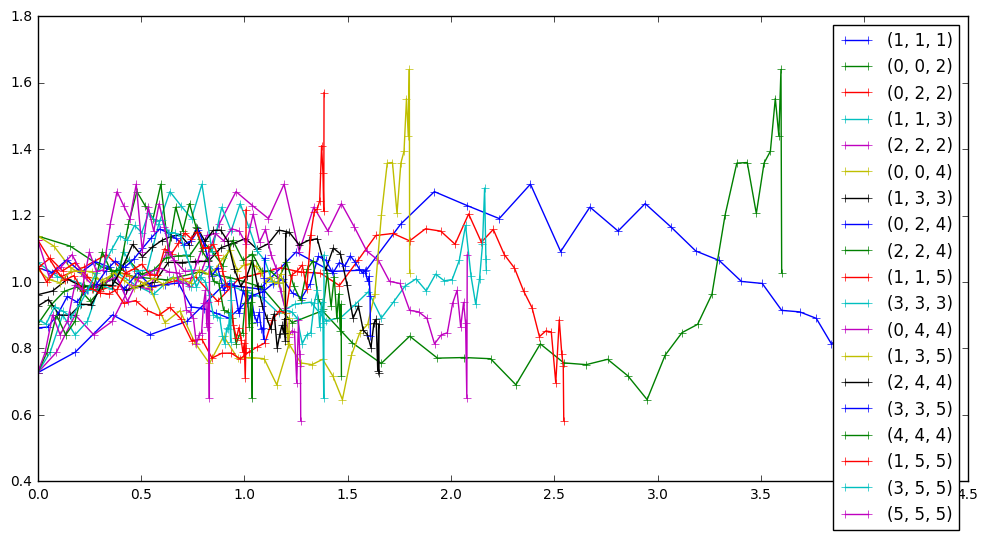

In [7]:
plt.figure(figsize=(12, 6))
for i in range(nhkl):
    plt.plot(lambdas[i], Rs[i], '+-', label=hkls[i])
plt.legend()

# Calculate xs

In [8]:
from bem import matter
# FCC
atoms = [matter.Atom('Ni', (0,0,0)), matter.Atom('Ni', (0.5, 0.5, 0)),
         matter.Atom('Ni', (0.5,0,0.5)), matter.Atom('Ni', (0, 0.5, 0.5))]
# a=3.5238 
a=3.60  # this is inferred from the d-spacing values in the original fortran file 
alpha = 90.
lattice = matter.Lattice(a=a, b=a, c=a, alpha=alpha, beta=alpha, gamma=alpha)
structure = fccNi = matter.Structure(atoms, lattice, sgid=225)

In [9]:
max_hkl_index = 5
from bem.diffraction import iter_peaks
peaks = list(iter_peaks(structure, T=300., max_index = max_hkl_index))
peaks = sorted(peaks, key = lambda k: -k.d) # sort peaks by d spacing 

In [10]:
for i in range(nhkl):
    assert hkls[i] == peaks[i].hkl

### R functions

In [11]:
def create_R_f(xs, ys):
    return lambda wavelen: np.interp(wavelen, xs, ys)
R_funcs = [create_R_f(l, R) for l, R in zip(lambdas, Rs)]

In [12]:
def xs_coh_el(uc_vol, diffpeaks, R_funcs, wavelen):
    vs = [np.abs(p.F)**2*p.d*p.mult*R(wavelen)*(p.d*2>wavelen) for p,R in zip(diffpeaks, R_funcs)]
    vs = np.array(vs) # unit fm^2
    if len(vs.shape) == 1:
        return np.sum(vs)/100 * wavelen*wavelen/(2*uc_vol) # unit: barn
    return np.sum(vs, axis=0)/100 * wavelen*wavelen/(2*uc_vol) # unit: barn

In [13]:
uc_vol = structure.lattice.volume

In [14]:
wavelen = np.arange(0, 4., 0.01)
xs = xs_coh_el(uc_vol, peaks, R_funcs, wavelen)

In [15]:
R1_funcs = [lambda w: w*0.+1 for i in range(nhkl)]
xs1 = xs_coh_el(uc_vol, peaks, R1_funcs, wavelen)

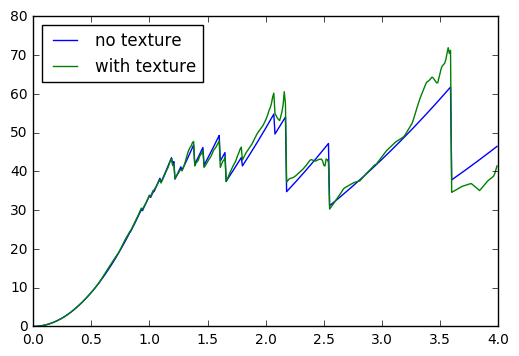

In [16]:
plt.figure()
plt.plot(wavelen, xs1, label='no texture')
plt.plot(wavelen, xs, label='with texture')
plt.legend(loc='upper left')